In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
airlines= pd.read_excel('Airlines+Data.xlsx')
airlines

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


Visualization and Data Preprocessing

In [3]:
airlines.shape

(96, 2)

In [5]:
airlines.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


In [6]:
airlines.info

<bound method DataFrame.info of         Month  Passengers
0  1995-01-01         112
1  1995-02-01         118
2  1995-03-01         132
3  1995-04-01         129
4  1995-05-01         121
..        ...         ...
91 2002-08-01         405
92 2002-09-01         355
93 2002-10-01         306
94 2002-11-01         271
95 2002-12-01         306

[96 rows x 2 columns]>

In [7]:
airlines.isnull().sum().sum()

0

In [8]:
airlines.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

In [9]:
airlines.set_index('Month', inplace=True)
airlines.head()

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


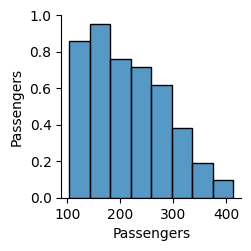

In [10]:
sns.pairplot(airlines)
plt.show()

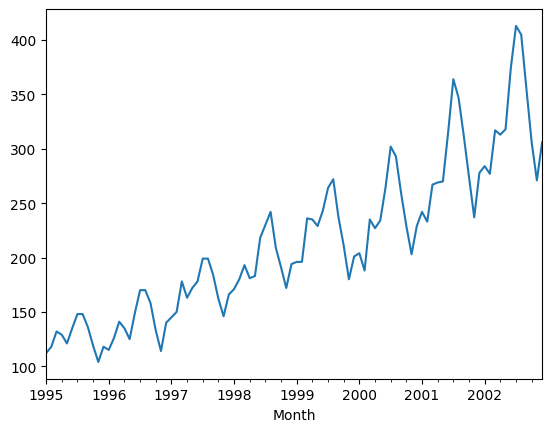

In [13]:
airlines.Passengers.plot()
plt.show()

<Axes: >

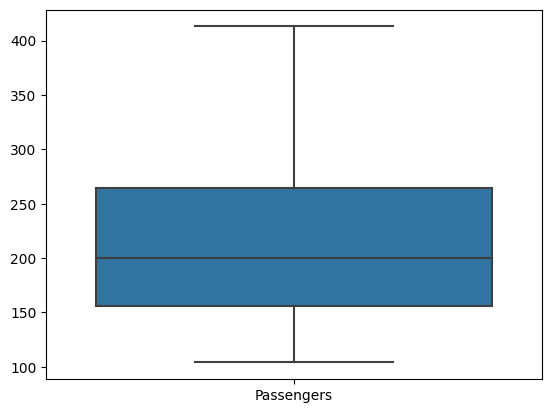

In [14]:
sns.boxplot(airlines)

array([[<Axes: title={'center': 'Passengers'}>]], dtype=object)

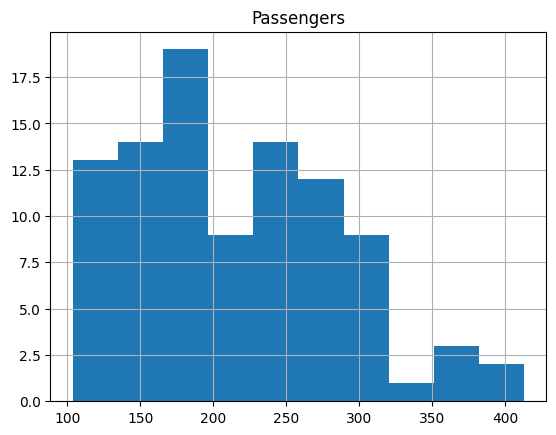

In [15]:
airlines.hist()

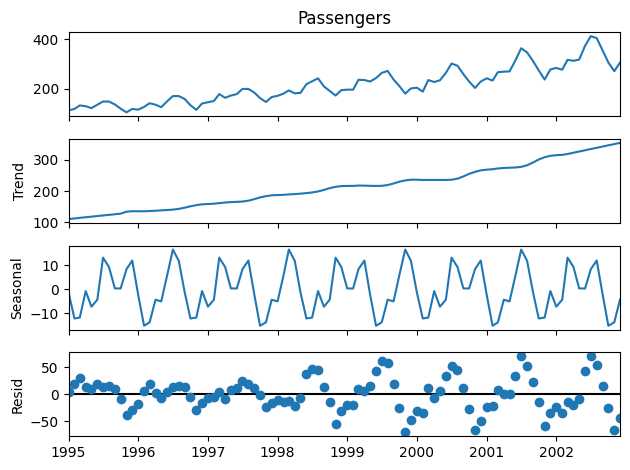

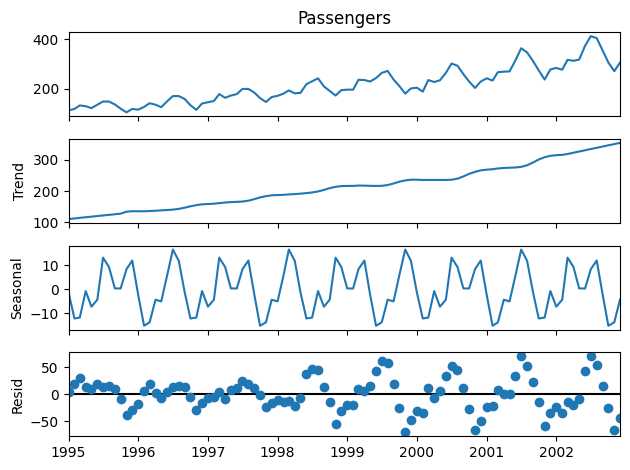

In [16]:
import statsmodels.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_ts_add=smf.tsa.seasonal_decompose(airlines['Passengers'],extrapolate_trend="freq",period=20)
seasonal_ts_add.plot()

<Axes: ylabel='Density'>

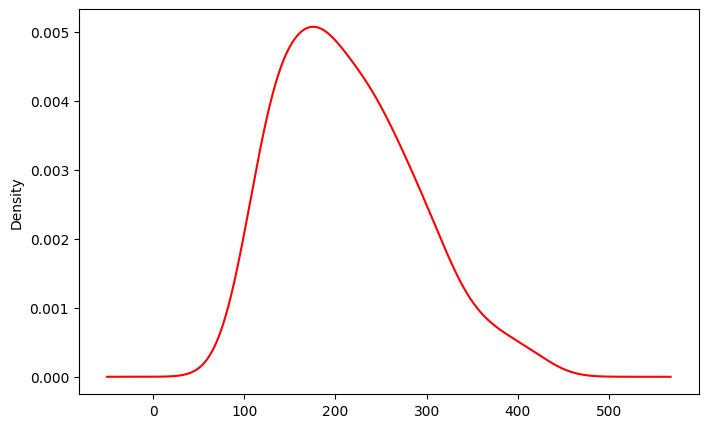

In [17]:
ax = plt.axes()
airlines['Passengers'].plot(kind = 'kde', figsize=(8,5), color = 'red')

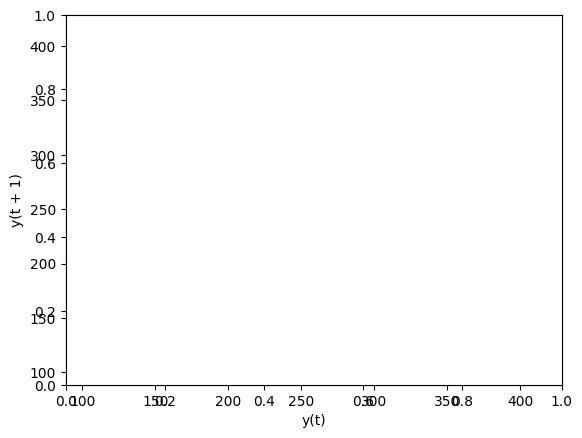

In [19]:
# Lagplot
from pandas.plotting import lag_plot

lag_plot(airlines['Passengers'])
ax = plt.axes()
plt.show()

Data Driven Forecasting Methods

In [20]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [22]:
# Splitting data into Train and Test (77/33)
Train = airlines.head(84)
Test = airlines.tail(12)

moving average method

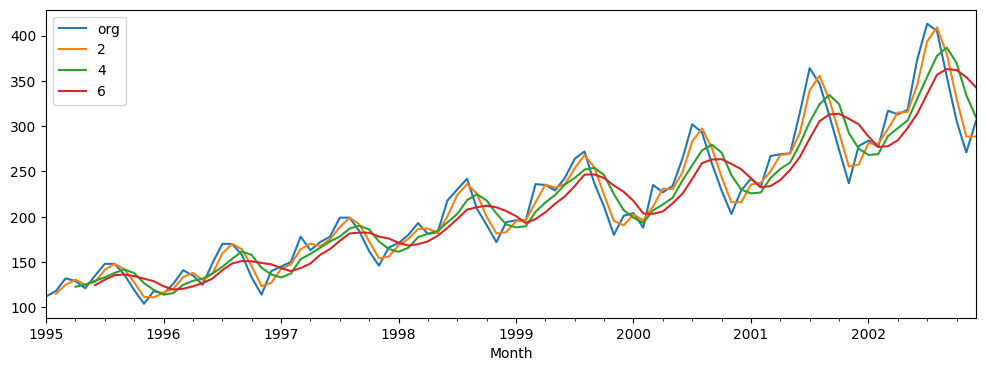

In [23]:
plt.figure(figsize=(12,4))
airlines.Passengers.plot(label="org")
for i in range(2,8,2):
    airlines["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

Evaluation Metric RMSE

In [24]:
def RMSE(org, pred):
    rmse=np.sqrt(np.mean((np.array(org)-np.array(pred))**2))
    return rmse

In [25]:
import warnings
warnings.filterwarnings("ignore")

Simple Exponential Method

In [26]:
ses_model = SimpleExpSmoothing(Train["Passengers"]).fit()
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_ses_model = RMSE(Test.Passengers, pred_ses)
rmse_ses_model

68.0067403134932

Holt method

In [27]:
hw_model = Holt(Train["Passengers"]).fit()
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_hw_model = RMSE(Test.Passengers, pred_hw)
rmse_hw_model

52.92194971240321

In [28]:
#Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(Train["Passengers"],seasonal="add",trend="add",seasonal_periods=4).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
rmse_hwe_add_add_model = RMSE(Test.Passengers, pred_hwe_add_add)
rmse_hwe_add_add_model

63.14440376379176

In [30]:
#Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(Train["Passengers"],seasonal="mul",trend="add",seasonal_periods=4).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
rmse_hwe_model_mul_add_model = RMSE(Test.Passengers, pred_hwe_mul_add)
rmse_hwe_model_mul_add_model

64.7248143801876


Model based Forecasting Methods

In [32]:
# Data preprocessing for models
airlines1 = airlines.copy()
airlines1.head()

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


In [33]:
airlines1["t"] = np.arange(1,97)
airlines1["t_squared"] = airlines1["t"]*airlines1["t"]

airlines1["log_psngr"] = np.log(airlines1["Passengers"])

airlines1.head()

,Passengers,t,t_squared,log_psngr
Month,,,,
1995-01-01,112,1,1,4.718499
1995-02-01,118,2,4,4.770685
1995-03-01,132,3,9,4.882802
1995-04-01,129,4,16,4.859812
1995-05-01,121,5,25,4.795791


In [36]:
# Splitting data into Train and Test (77/33)
Train = airlines1.head(84)
Test = airlines1.tail(12)

In [37]:
#linear model
import statsmodels.formula.api as smf

linear_model = smf.ols('Passengers~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear_model = RMSE(Test['Passengers'], pred_linear)
rmse_linear_model

53.19923653480278

In [38]:
#exponential model
Exp = smf.ols('log_psngr~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp_model = RMSE(Test['Passengers'], np.exp(pred_Exp))
rmse_Exp_model

46.05736110315654

In [39]:
#quadratic model
Quad = smf.ols('Passengers~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad_model = RMSE(Test['Passengers'], pred_Quad)
rmse_Quad_model

48.05188897933164

ARIMA model

In [40]:
series = airlines.copy()

In [41]:
series

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121
...,...
2002-08-01,405
2002-09-01,355
2002-10-01,306


In [42]:
# separate out a validation dataset
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 84, Validation 12



Persistence/ Base mode

In [44]:
# evaluate a persistence model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = train.values
X = X.astype('float32')
train_size = int(len(X) * 0.715)
train, test = X[0:train_size], X[train_size:]

In [45]:
print(train.shape)
print(test.shape)

(60,)
(24,)


In [46]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=201.000, Expected=204.000
>Predicted=204.000, Expected=188.000
>Predicted=188.000, Expected=235.000
>Predicted=235.000, Expected=227.000
>Predicted=227.000, Expected=234.000
>Predicted=234.000, Expected=264.000
>Predicted=264.000, Expected=302.000
>Predicted=302.000, Expected=293.000
>Predicted=293.000, Expected=259.000
>Predicted=259.000, Expected=229.000
>Predicted=229.000, Expected=203.000
>Predicted=203.000, Expected=229.000
>Predicted=229.000, Expected=242.000
>Predicted=242.000, Expected=233.000
>Predicted=233.000, Expected=267.000
>Predicted=267.000, Expected=269.000
>Predicted=269.000, Expected=270.000
>Predicted=270.000, Expected=315.000
>Predicted=315.000, Expected=364.000
>Predicted=364.000, Expected=347.000
>Predicted=347.000, Expected=312.000
>Predicted=312.000, Expected=274.000
>Predicted=274.000, Expected=237.000
>Predicted=237.000, Expected=278.000
RMSE: 29.058


In [47]:
rmse_Persistence_model = 29.058

ARIMA Hyperparameters

In [48]:
series = pd.read_excel('Airlines+Data.xlsx', header=0, index_col=0, parse_dates=True)

In [49]:
series.head()

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


In [50]:
# separate out a validation dataset
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 84, Validation 12


In [51]:
# grid search ARIMA parameters for a time series

import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.715)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
# model_fit = model.fit(disp=0)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [52]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [53]:
# load dataset
train = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(train.values, p_values, d_values, q_values)

Best ARIMANone RMSE=inf


In [54]:
rmse_ARIMA_model = 24.650

Build Model based on the optimized values

In [55]:
# load data
train = pd.read_csv('dataset.csv', header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

Combine train and test data and build final model

In [56]:
# fit model
data = pd.read_excel('Airlines+Data.xlsx', header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')